## プログラム比較

In [1]:
import numpy as np
import pandas as pd
import datetime

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
cm_path = "./data/1708_kanto_actual_FACT10901.xlsx"
brand_path = "./data/1708_kanto_brand_target.xlsx"

### 下準備

In [4]:
df_brand = pd.read_excel(brand_path)

In [5]:
# 合計している行や、発注期間が違うために別にしている行を取り除く。
df_brand = df_brand.dropna(how = 'all', subset=['1w','2w','3w','4w','5w','6w']).reset_index(drop=True)

In [6]:
# 今回 30 秒のブランドが１つしかないので、15秒だけを考える。
df_brand = df_brand[df_brand['秒数'] == 15].reset_index(drop=True)

In [7]:
df_brand.head(1)

,秒数,ターゲット階層,ブランドコード,ブランド,発注期間,禁止時間,隣接緩和,発注金額（千円）,目標TRP,1w,2w,3w,4w,5w,6w,目標GRP,A本数,深夜本数,A+深夜TRPｼｪｱ,目標R3+
0,15,女 18～34才,3S,カネボウ／ＳＡＬＡ,18-31,NaN,NaN,15163.0,270.6,0.0,0.0,0.214286,0.5,0.285714,0.0,481.4,NaN,NaN,NaN,34.483866


In [8]:
def span_isok(row):
    '''クソコード。うまいことやりたい。'''
    day_spans = row['発注期間'].split('*')
    if len(day_spans) == 1:
        day_span = day_spans[0]
        s,e   = [datetime.datetime(2017, 8, int(day)) for day in day_span.split('-')]
        return lambda x:(s<=x) and (x<=e)
    
    elif len(day_spans) == 2:
        day_span1 = day_spans[0]
        day_span2 = day_spans[1]
        s1,e1   = [datetime.datetime(2017, 8, int(day)) for day in day_span1.split('-')]
        s2,e2   = [datetime.datetime(2017, 8, int(day)) for day in day_span2.split('-')]
        return lambda x:((s1<=x) and (x<=e1)) or ((s2<=x) and (x<=e2))
    
    else:
        print("ERROR: 発注期間が3つ以上あります。")
        return None

In [9]:
df_brand['発注期間'] = df_brand.apply(lambda x:span_isok(x), axis=1)

In [10]:
#  1. 各ブランドごとに、目標となる「週ごとのTRP」を計算する。
week_cols = ['1w', '2w', '3w', '4w', '5w', '6w']
for week_col in week_cols:
    df_brand[week_col] = df_brand[week_col] * df_brand['目標TRP']

In [11]:
brand_cols = ['秒数','ターゲット階層','ブランドコード','発注期間','禁止時間'] + week_cols

In [12]:
# 2. 「発注期間」や「禁止時間」などもブランドごとに記録する。
df_brand = df_brand[brand_cols]
df_brand.columns = ['sec','target','code','day_span','bad_time'] + week_cols

In [13]:
df_brand.head(1)

,sec,target,code,day_span,bad_time,1w,2w,3w,4w,5w,6w
0,15,女 18～34才,3S,<function span_isok.<locals>.<lambda> at 0x7f5...,NaN,0.0,0.0,57.985714,135.3,77.314286,0.0


***

In [14]:
# 3. ターゲット階層が同じでCMの秒数も同じブランドはひとまとめにする。
df_brand_gp = df_brand.groupby(["sec","target"]).sum().reset_index()[['sec','target'] + week_cols]

In [15]:
target_list = list(set(df_brand_gp.target))

In [16]:
# この後のために、index を target 階層に変更しておく。
df_brand_gp = df_brand_gp.set_index('target')

In [17]:
# 目標を達成している(発注していない)ブランドグループは True. で初期化。
df_brand_gp[ df_brand_gp == 0 ] = True

In [18]:
# 目標を達成していないブランドグループは False. で初期化。
df_brand_gp.loc[:,week_cols] = df_brand_gp.loc[:,week_cols].where(df_brand_gp.loc[:,week_cols] == True, False)

In [19]:
df_brand_gp

,sec,1w,2w,3w,4w,5w,6w
target,,,,,,,
女 18～34才,15,False,False,False,False,False,True
女 25～39才,15,False,False,False,False,False,True
女 35～49才,15,False,False,False,False,False,True
女 50～59才,15,True,False,False,True,True,True


***

In [20]:
# 4. `week_dict` を作成する。これは、1w と 日にちの対応関係を示す。

In [21]:
# 1w の最初の日にちを設定
start_day = datetime.datetime(2017, 7, 31)

In [22]:
week_dict = dict()
for w in range(1,7):
    for d in range(7):
        week_dict[start_day + datetime.timedelta(days= 7*(w-1) + d)] = "{}w".format(w)

***

In [61]:
df_cm = pd.read_excel(cm_path)

In [62]:
df_cm.head(1)

,Key,ｱｸﾁｭｱﾙ,局,放送日,曜日,開始時刻,終了時刻,Aﾗﾝｸﾌﾗｸﾞ,区分,秒数,...,見積 世帯(%),見積 個人(%),見積+追跡GRP,見積+追跡TRP,TRP差分,TRP達成率,女 18～34才,女 25～39才,女 35～49才,女 50～59才
0,CXT4294806:10PT,追跡,CXT,2017-08-01,火,06:10,08:00,NaN,PT,15,...,8.3,10.1,8.6,8.7,-1.4,0.861386,2.3,2.5,8.7,9.5


In [64]:
df_cm.head(100)

,Key,ｱｸﾁｭｱﾙ,局,放送日,曜日,開始時刻,終了時刻,Aﾗﾝｸﾌﾗｸﾞ,区分,秒数,...,見積 世帯(%),見積 個人(%),見積+追跡GRP,見積+追跡TRP,TRP差分,TRP達成率,女 18～34才,女 25～39才,女 35～49才,女 50～59才
0,CXT4294806:10PT,追跡,CXT,2017-08-01,火,06:10,08:00,NaN,PT,15,...,8.3,10.1,8.6,8.7,-1.4,0.861386,2.3,2.5,8.7,9.5
1,CXT4294806:10PT,追跡,CXT,2017-08-01,火,06:10,08:00,NaN,PT,15,...,8.3,10.1,8.6,8.7,-1.4,0.861386,2.3,2.5,8.7,9.5
2,CXT4294806:10PT,追跡,CXT,2017-08-01,火,06:10,08:00,NaN,PT,15,...,8.3,10.1,8.6,8.7,-1.4,0.861386,2.3,2.5,8.7,9.5
3,CXT4294806:10PT,追跡,CXT,2017-08-01,火,06:10,08:00,NaN,PT,15,...,8.3,10.1,8.6,8.7,-1.4,0.861386,2.3,2.5,8.7,9.5
4,CXT4294806:10PT,追跡,CXT,2017-08-01,火,06:10,08:00,NaN,PT,15,...,8.3,10.1,8.6,8.7,-1.4,0.861386,2.3,2.5,8.7,9.5
5,CXT4294808:00PT,追跡,CXT,2017-08-01,火,08:00,09:50,NaN,PT,15,...,7.3,5.9,7.6,6.3,0.4,1.067797,1.3,1.9,6.3,7.5
6,CXT4294808:00PT,追跡,CXT,2017-08-01,火,08:00,09:50,NaN,PT,15,...,7.3,5.9,7.6,6.3,0.4,1.067797,1.3,1.9,6.3,7.5
7,CXT4294808:00PT,追跡,CXT,2017-08-01,火,08:00,09:50,NaN,PT,15,...,7.3,5.9,7.6,6.3,0.4,1.067797,1.3,1.9,6.3,7.5
8,CXT4294808:00PT,追跡,CXT,2017-08-01,火,08:00,09:50,NaN,PT,15,...,7.3,5.9,7.6,6.3,0.4,1.067797,1.3,1.9,6.3,7.5
9,CXT4294809:50PT,追跡,CXT,2017-08-01,火,09:50,11:25,NaN,PT,15,...,4.1,3.1,4.7,2.2,-0.9,0.709677,1.7,1.8,2.2,2.6


In [25]:
# 今回 30 秒のブランドが１つしかないので、15秒だけを考える。
df_cm = df_cm[df_cm['秒数'] == 15].reset_index(drop=True)

In [26]:
cm_cols = ['秒数','放送日','開始時刻', '終了時刻'] + target_list

In [27]:
# 5. CMの情報とブランドグループのターゲット階層の視聴率を抜き出す。
df_cm = df_cm[cm_cols]
df_cm.columns = ['sec','day','start_time','end_time'] + target_list

In [28]:
df_cm.head(1)

,sec,day,start_time,end_time,女 18～34才,女 50～59才,女 25～39才,女 35～49才
0,15,2017-08-01,06:10,08:00,2.3,9.5,2.5,8.7


In [29]:
# 6. 各CM枠に関して、「二番目に大きな値」で割った比率を求める。

In [30]:
def cal_cm_value(row):
    '''二番目に大きな値が０の時に inf がでないように微小項を加える。'''
    second_val = sorted(row, reverse=True)[1]
    return row/(second_val+0.001)

In [31]:
target_list_rate = [col+'_rate' for col in target_list]

In [32]:
df_cm_rate = df_cm[target_list].apply(lambda x:cal_cm_value(x),axis=1)
df_cm_rate.columns = target_list_rate

In [33]:
# 割合は、arr型で保存する。
cm_rate_arr = np.array(df_cm_rate)

In [34]:
# index と階層名を関係付ける。
target_dict = dict(enumerate(target_list))

***

### データフレームの確認

In [35]:
df_brand.head(1)

,sec,target,code,day_span,bad_time,1w,2w,3w,4w,5w,6w
0,15,女 18～34才,3S,<function span_isok.<locals>.<lambda> at 0x7f5...,NaN,0.0,0.0,57.985714,135.3,77.314286,0.0


In [36]:
df_brand_gp

,sec,1w,2w,3w,4w,5w,6w
target,,,,,,,
女 18～34才,15,False,False,False,False,False,True
女 25～39才,15,False,False,False,False,False,True
女 35～49才,15,False,False,False,False,False,True
女 50～59才,15,True,False,False,True,True,True


In [37]:
df_cm.head(1)

,sec,day,start_time,end_time,女 18～34才,女 50～59才,女 25～39才,女 35～49才
0,15,2017-08-01,06:10,08:00,2.3,9.5,2.5,8.7


In [38]:
week_dict[start_day]

'1w'

In [39]:
target_dict

{0: '女 18～34才', 1: '女 50～59才', 2: '女 25～39才', 3: '女 35～49才'}

***

### アルゴリズム

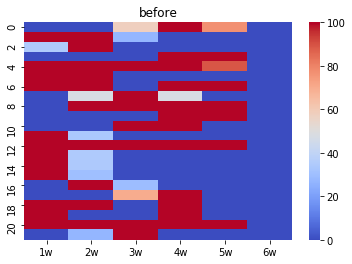

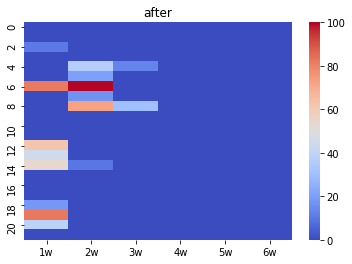

In [40]:
cm_dict = dict()

'''開始前の状態を表示'''
sns.heatmap(df_brand[week_cols], cmap="coolwarm", vmax=100, vmin=0)
plt.title("before")
plt.show()

while True:
    # 全体終了条件
    if cm_rate_arr.sum() == 0:
        break
        
    max_index, max_bg_int = np.unravel_index(cm_rate_arr.argmax(), cm_rate_arr.shape) # 最も大きな値を取るCM枠を取り出す。
    max_bg      = target_dict[max_bg_int] 
    max_trp     = df_cm.loc[max_index,max_bg] # その枠のそのターゲット層に対する TRP
    max_day     = df_cm.loc[max_index,"day"]  # その枠の放送日
    max_day_id  = week_dict[max_day]          # nw で表した時の番号を調べる。
    
    # df_brand_gp を参照し、すでに目標を達成している場合は、値を置き換えて終了する。
    if df_brand_gp.loc[max_bg, max_day_id]:
        cm_rate_arr[max_index][max_bg_int] = 0
        continue
        
    # df_brand を参照し、取得可能かを調べる。すでに目標を達成しているなら割り当てしない。
    df_tmp = df_brand[(df_brand.target == max_bg) &
                      (df_brand.day_span.apply(lambda x:x(max_day))) &
                      (df_brand[max_day_id] > 0)]
    
    if len(df_tmp) == 0: # まだ満たしていないブランドがあれば
        cm_rate_arr[max_index][max_bg_int] = 0
        continue
        
    # さらに、禁止条件や連続の禁止などを加える必要がある。
    
    # 取得可能な場合
    allo_code = df_tmp.sample().code.values[0] # ランダムチョイス。
    df_brand.loc[df_brand.code == allo_code, max_day_id] -= max_trp # TRPを引く。

    # 目標を達成した場合、他の全てのブランドも目標を達成していれば、ブランドグループをTRUEに置き換える。
    if df_brand.loc[df_brand.code == allo_code, max_day_id].values[0] <=0:
        if (df_brand[(df_brand.target == max_bg)][max_day_id] <= 0).all():
            df_brand_gp.loc[max_bg, max_day_id] = True                

    cm_dict[max_index] = allo_code
    cm_rate_arr[max_index] = 0 # 全て0で置き換える。
    
'''終了後の状態を表示'''
sns.heatmap(df_brand[week_cols], cmap="coolwarm", vmax=100, vmin=0)
plt.title("after")
plt.show()

### 結果

In [41]:
def Visualization(row):
    try:
        code = cm_dict[row]
        return code
    except KeyError:
        return "Not allocated"

In [42]:
df_cm["allocate"] = df_cm.reset_index()["index"].apply(lambda x:Visualization(x))

In [43]:
print("余剰枠数: {}".format(len(df_cm[df_cm.allocate == "Not allocated"])))
print("総枠数　: {}".format(len(df_cm)))
print("割合　　: {:.3f}%".format( len(df_cm[df_cm.allocate == "Not allocated"]) / len(df_cm) * 100))

余剰枠数: 242
総枠数　: 2452
割合　　: 9.869%


In [56]:
df_cm[df_cm.allocate == "Not allocated"].day.apply(lambda x:week_dict[x]).reset_index().groupby("day").size()

day
1w      1
2w      3
3w      1
4w    163
5w     74
dtype: int64

In [58]:
# かなりの枠が残ってしまっている。ただ、上を見ても分かる通り、4wや5wなどの余剰枠が残っている印象。
# 発注期間内ではないから取得できないといったものはあまりなさげ。

In [45]:
youbis = ["月","火","水","木","金","土","日"]

In [46]:
# そもそも、いくつのブランドが受け入れOKを出しているのかを調べる。
day = datetime.datetime(2017, 8, 1)
index = 1
while True:
    youbi = youbis[index]
    true_num = df_brand.day_span.apply(lambda x:x(day)).sum()
    cm_num   = len(df_cm[df_cm.day == day])
    print("{:>2} 日({})： {:>2}ブランド {:>3}枠 {:>4}枠/ブランド".format(day.day, youbi, true_num, cm_num, round(cm_num/true_num, 1)))
    day += datetime.timedelta(days= 1)
    index = (index+1)%7
    if day >= datetime.datetime(2017, 9, 1):
        break

 1 日(火)： 12ブランド 130枠 10.8枠/ブランド
 2 日(水)： 12ブランド 121枠 10.1枠/ブランド
 3 日(木)： 12ブランド 110枠  9.2枠/ブランド
 4 日(金)： 12ブランド  79枠  6.6枠/ブランド
 5 日(土)： 13ブランド  49枠  3.8枠/ブランド
 6 日(日)： 13ブランド  42枠  3.2枠/ブランド
 7 日(月)： 12ブランド  64枠  5.3枠/ブランド
 8 日(火)：  9ブランド  84枠  9.3枠/ブランド
 9 日(水)： 10ブランド  67枠  6.7枠/ブランド
10 日(木)： 10ブランド  74枠  7.4枠/ブランド
11 日(金)：  9ブランド  61枠  6.8枠/ブランド
12 日(土)： 10ブランド  70枠  7.0枠/ブランド
13 日(日)：  9ブランド  60枠  6.7枠/ブランド
14 日(月)：  7ブランド  64枠  9.1枠/ブランド
15 日(火)：  5ブランド  47枠  9.4枠/ブランド
16 日(水)：  6ブランド  49枠  8.2枠/ブランド
17 日(木)：  6ブランド  37枠  6.2枠/ブランド
18 日(金)：  7ブランド  43枠  6.1枠/ブランド
19 日(土)：  8ブランド  56枠  7.0枠/ブランド
20 日(日)：  7ブランド  57枠  8.1枠/ブランド
21 日(月)：  9ブランド 121枠 13.4枠/ブランド
22 日(火)： 10ブランド 115枠 11.5枠/ブランド
23 日(水)： 10ブランド 112枠 11.2枠/ブランド
24 日(木)： 11ブランド 112枠 10.2枠/ブランド
25 日(金)： 11ブランド 100枠  9.1枠/ブランド
26 日(土)： 11ブランド  95枠  8.6枠/ブランド
27 日(日)： 11ブランド  85枠  7.7枠/ブランド
28 日(月)：  8ブランド 103枠 12.9枠/ブランド
29 日(火)：  8ブランド  78枠  9.8枠/ブランド
30 日(水)：  8ブランド  82枠 10.2枠/ブランド
31 日(木)：  8ブランド  85枠 10.6枠/ブランド
